This code is made by Chas (and AlexR) and was modified for python3 by AlexF
In-n-Out in progress

In [16]:
import numpy as np
import pickle as pickle
import scipy.interpolate as interp
import scipy.signal as signal
import scipy.optimize as opti
import scipy, sys, time
import matplotlib.pyplot as plt
from matplotlib.mlab import psd


In [17]:
# bead radius [µm] (certain it shouldn't be diameter)
rbead = 2.4e-6 #float(sys.argv[1])
# separation attractor [µm] - to surface of the bead
sep = 7.5e-6 #float(sys.argv[2])
# difference in height of attractor and bead [µm]
height = 0 #float(sys.argv[3])

# load the density profile of the attractor (took the one AlexR and Chas have produced)
rhopath = 'rho_arr.p'
rho, xx, yy, zz = pickle.load(open(rhopath, 'rb'), encoding="latin1") # first change, encoding to latin1 instead of ASCII
print("Density Loaded.")
sys.stdout.flush()

Density Loaded.


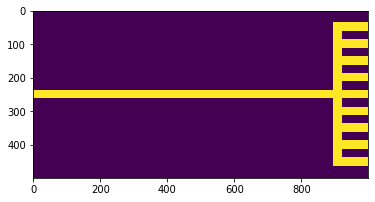

In [18]:
plt.imshow(rho[0:499,0:999,int(.5*len(zz))])

In [19]:
xx = np.array(xx) # maxe array for x
yy = np.array(yy) # make array for y
zz = np.array(zz) # make array for z

xinds = np.abs(xx) <= 25.0e-6 #
yinds = np.abs(yy) <= 80.0e-6 #
zinds = np.abs(zz) <= 5.0e-6 #

xx2 = xx[xinds] #
yy2 = yy[yinds] #
zz2 = zz[zinds] #
rho2 = rho[xinds,:,:][:,yinds,:] #


# produce empty arrays 

xzeros = np.zeros(len(xx))
yzeros = np.zeros(len(yy))
zzeros = np.zeros(len(zz))

xzeros2 = np.zeros(len(xx2))
yzeros2 = np.zeros(len(yy2))
zzeros2 = np.zeros(len(zz2))

dx = np.abs(xx[1] - xx[0])
dy = np.abs(yy[1] - yy[0])
dz = np.abs(zz[1] - zz[0])

cell_volume = dx * dy * dz
m = rho * cell_volume
m2 = rho2 * cell_volume

In [41]:

G = 6.67e-11     # m^3 / (kg s^2)
rhobead = 1550.

travel = 500e-6 # travel
cent = 0.0e-6 # where to start
Npoints = 1001 # how many points for each direction
beadposvec = np.linspace(cent - travel*0.5, cent + travel*0.5, Npoints)
beadposvec2 = np.linspace(0, travel, 2*(Npoints-1) + 1)

lambdas = np.logspace(-6.3, -3, 100)
lambdas = lambdas[::-1]

In [29]:
# where to put the results and how to name them

respath = 'results/'
respath = respath + 'rbead_' + str(rbead)
respath = respath + '_sep_' + str(sep)
respath = respath + '_height_' + str(height)
respath = respath + '.p'
results_dic = {}
results_dic['order'] = 'Rbead, Sep, Height, Yuklambda'



finger_inds = np.array([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0])

In [30]:
def find_ind(pos):
    if np.abs(pos) <= 25e-6:
        ind = 0
    elif np.abs(pos) > 25e-6:
        if np.abs(pos) <= 75e-6:
            if pos > 0:
                ind = 1.0
            elif pos < 0:
                ind = -1.0
        elif np.abs(pos) > 75e-6:
            if np.abs(pos) <= 125e-6:
                if pos > 0:
                    ind = 2.0
                if pos < 0:
                    ind = -2.0
            elif np.abs(pos) > 125e-6:
                if np.abs(pos) <= 175e-6:
                    if pos > 0:
                        ind = 3.0
                    if pos < 0:
                        ind = -3.0
                elif np.abs(pos) > 175e-6:
                    if pos > 0:
                        ind = 4.0
                    if pos < 0:
                        ind = -4.0

    newpos = pos - ind * 50e-6

    return ind, newpos


def dist(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)

def dist_p_arrp(p1, xs, ys, zs):
    xnew = (xs - p1[0])**2
    ynew = (ys - p1[1])**2
    znew = (zs - p1[2])**2
    return np.sqrt(np.add.outer(np.add.outer(xnew, ynew), znew))

In [31]:
results_dic[rbead] = {}
results_dic[rbead][sep] = {}
results_dic[rbead][sep][height] = {}


Gterm = 2. * rbead**3

GforcecurveX = []
GforcecurveY = []
GforcecurveZ = []

In [32]:
for ind, xpos in enumerate(beadposvec2):

    beadpos = [cent, ypos+rbead+sep, height]
    s = dist_p_arrp(beadpos, xx2, yy2, zz2) - rbead

    # These are used to compute projections and thus need to maintain sign
    xsep = dist_p_arrp([xpos, 0, 0], xx2, yzeros2, zzeros2)
    xind = np.argmin(np.abs(xx2 - xpos))
    xsep[:xind,:,:] *= -1.0

    # We a priori know that all yseps should be negative
    ysep = dist_p_arrp([0, sep+rbead, 0], xzeros2, yy2, zzeros2)
    ysep *= -1.0

    zsep = dist_p_arrp([0, 0, height], xzeros2, yzeros2, zz2)
    zind = np.argmin(np.abs(zz2 - height))
    zsep[:,:,:zind] *= -1.0

    xprojection = xsep / (s + rbead)
    yprojection = ysep / (s + rbead)
    zprojection = zsep / (s + rbead)

    prefac = ((2. * G * m2 * rhobead * np.pi) / (3. * (rbead + s)**2))

    xtotforce = np.sum(prefac * Gterm * xprojection)
    ytotforce = np.sum(prefac * Gterm * yprojection)
    ztotforce = np.sum(prefac * Gterm * zprojection)

    # SWAP X AND Y AXES TO MATCH DATA AXES
    GforcecurveX.append(ytotforce)
    GforcecurveY.append(xtotforce)
    GforcecurveZ.append(ztotforce)

GforcecurveX = np.array(GforcecurveX)
GforcecurveY = np.array(GforcecurveY)
GforcecurveZ = np.array(GforcecurveZ)

GX = interp.interp1d(beadposvec2, GforcecurveX, kind='cubic')
GY = interp.interp1d(beadposvec2, GforcecurveY, kind='cubic')
GZ = interp.interp1d(beadposvec2, GforcecurveZ, kind='cubic')

newGX = np.zeros(len(beadposvec))
newGY = np.zeros(len(beadposvec))
newGZ = np.zeros(len(beadposvec))

for ind, pos in enumerate(beadposvec):
    if np.abs(pos) - 225e-6 > 0:
        newGX[ind] = 0.0
        newGY[ind] = 0.0
        newGZ[ind] = 0.0
        continue

    finger_ind, newpos = find_ind(pos)
    width = 50.0e-6

    newGX[ind] = np.sum(GX(newpos + (finger_inds+finger_ind) * width))
    newGY[ind] = np.sum(GY(newpos + (finger_inds+finger_ind) * width))
    newGZ[ind] = np.sum(GZ(newpos + (finger_inds+finger_ind) * width))  

print('Computed normal grav')
sys.stdout.flush()

0 -0.0005
1 -0.0004995
2 -0.000499
3 -0.0004985
4 -0.000498
5 -0.0004975
6 -0.000497
7 -0.0004965
8 -0.000496
9 -0.0004955000000000001
10 -0.000495
11 -0.0004945
12 -0.000494
13 -0.0004935
14 -0.0004930000000000001
15 -0.0004925
16 -0.000492
17 -0.0004915
18 -0.000491
19 -0.0004905
20 -0.00049
21 -0.0004895
22 -0.000489
23 -0.0004885
24 -0.000488
25 -0.00048750000000000003
26 -0.000487
27 -0.0004865
28 -0.000486
29 -0.00048550000000000004
30 -0.000485
31 -0.0004845
32 -0.000484
33 -0.0004835
34 -0.00048300000000000003
35 -0.0004825
36 -0.000482
37 -0.0004815
38 -0.00048100000000000004
39 -0.0004805
40 -0.00048
41 -0.0004795
42 -0.000479
43 -0.00047850000000000003
44 -0.000478
45 -0.0004775
46 -0.000477
47 -0.00047650000000000004
48 -0.000476
49 -0.0004755
50 -0.000475
51 -0.0004745
52 -0.00047400000000000003
53 -0.0004735
54 -0.000473
55 -0.0004725
56 -0.00047200000000000003
57 -0.0004715
58 -0.000471
59 -0.0004705
60 -0.00047000000000000004
61 -0.00046950000000000003
62 -0.000469
63 -

599 -0.00020050000000000005
600 -0.00020000000000000004
601 -0.00019950000000000002
602 -0.000199
603 -0.0001985
604 -0.00019800000000000004
605 -0.00019750000000000003
606 -0.00019700000000000002
607 -0.0001965
608 -0.00019600000000000005
609 -0.00019550000000000004
610 -0.00019500000000000002
611 -0.0001945
612 -0.000194
613 -0.00019350000000000004
614 -0.00019300000000000003
615 -0.00019250000000000002
616 -0.000192
617 -0.00019150000000000005
618 -0.00019100000000000003
619 -0.00019050000000000002
620 -0.00019
621 -0.0001895
622 -0.00018900000000000004
623 -0.00018850000000000003
624 -0.00018800000000000002
625 -0.0001875
626 -0.00018700000000000005
627 -0.00018650000000000003
628 -0.00018600000000000002
629 -0.0001855
630 -0.00018500000000000005
631 -0.00018450000000000004
632 -0.00018400000000000003
633 -0.00018350000000000002
634 -0.000183
635 -0.00018250000000000004
636 -0.00018200000000000003
637 -0.00018150000000000002
638 -0.000181
639 -0.00018050000000000005
640 -0.00018000

1056 2.799999999999992e-05
1057 2.8499999999999988e-05
1058 2.8999999999999946e-05
1059 2.9500000000000012e-05
1060 2.999999999999997e-05
1061 3.0499999999999928e-05
1062 3.0999999999999995e-05
1063 3.149999999999995e-05
1064 3.200000000000002e-05
1065 3.249999999999998e-05
1066 3.2999999999999935e-05
1067 3.35e-05
1068 3.399999999999996e-05
1069 3.449999999999992e-05
1070 3.499999999999998e-05
1071 3.549999999999994e-05
1072 3.600000000000001e-05
1073 3.6499999999999966e-05
1074 3.6999999999999924e-05
1075 3.749999999999999e-05
1076 3.799999999999995e-05
1077 3.8500000000000014e-05
1078 3.899999999999997e-05
1079 3.949999999999993e-05
1080 3.9999999999999996e-05
1081 4.0499999999999954e-05
1082 4.099999999999991e-05
1083 4.149999999999998e-05
1084 4.199999999999994e-05
1085 4.25e-05
1086 4.299999999999996e-05
1087 4.349999999999992e-05
1088 4.3999999999999985e-05
1089 4.449999999999994e-05
1090 4.500000000000001e-05
1091 4.549999999999997e-05
1092 4.5999999999999925e-05
1093 4.6499999

1509 0.00025449999999999995
1510 0.0002549999999999999
1511 0.0002555
1512 0.00025599999999999993
1513 0.0002565
1514 0.00025699999999999996
1515 0.0002574999999999999
1516 0.000258
1517 0.00025849999999999994
1518 0.000259
1519 0.00025949999999999997
1520 0.0002599999999999999
1521 0.0002605
1522 0.00026099999999999995
1523 0.0002614999999999999
1524 0.00026199999999999997
1525 0.00026249999999999993
1526 0.000263
1527 0.00026349999999999995
1528 0.0002639999999999999
1529 0.0002645
1530 0.00026499999999999994
1531 0.0002655
1532 0.00026599999999999996
1533 0.0002664999999999999
1534 0.000267
1535 0.00026749999999999994
1536 0.000268
1537 0.00026849999999999997
1538 0.0002689999999999999
1539 0.0002695
1540 0.00026999999999999995
1541 0.0002704999999999999
1542 0.000271
1543 0.00027149999999999993
1544 0.000272
1545 0.00027249999999999996
1546 0.0002729999999999999
1547 0.0002735
1548 0.00027399999999999994
1549 0.0002745
1550 0.00027499999999999996
1551 0.0002754999999999999
1552 0.0

1963 0.00048149999999999994
1964 0.000482
1965 0.00048249999999999986
1966 0.0004829999999999999
1967 0.0004835
1968 0.00048399999999999984
1969 0.0004844999999999999
1970 0.00048499999999999997
1971 0.00048550000000000004
1972 0.0004859999999999999
1973 0.00048649999999999995
1974 0.000487
1975 0.00048749999999999987
1976 0.00048799999999999994
1977 0.0004885
1978 0.0004889999999999999
1979 0.0004894999999999999
1980 0.00049
1981 0.0004905
1982 0.0004909999999999999
1983 0.0004915
1984 0.000492
1985 0.0004924999999999999
1986 0.000493
1987 0.0004935
1988 0.0004939999999999999
1989 0.0004944999999999999
1990 0.000495
1991 0.0004954999999999998
1992 0.0004959999999999999
1993 0.0004965
1994 0.000497
1995 0.0004974999999999999
1996 0.000498
1997 0.0004985
1998 0.0004989999999999999
1999 0.0004994999999999999
2000 0.0005
Computed normal grav


In [13]:
for yukind, yuklambda in enumerate(lambdas):
    per = int(100. * float(yukind) / float(len(lambdas)))
    if not per % 1:
        print(str(per) + ',',)
    sys.stdout.flush()

    func = np.exp(-2. * rbead / yuklambda) * (1. + rbead / yuklambda) + rbead / yuklambda - 1.

    yukforcecurveX = []
    yukforcecurveY = []
    yukforcecurveZ = []
    for ind, xpos in enumerate(beadposvec2):

        beadpos = [xpos, sep+rbead, height]

        s = dist_p_arrp(beadpos, xx2, yy2, zz2) - rbead
        # These are used to compute projections and thus need to maintain sign
        xsep = dist_p_arrp([xpos, 0, 0], xx2, yzeros2, zzeros2)
        xind = np.argmin(np.abs(xx2 - xpos))
        xsep[:xind,:,:] *= -1.0

        # We a priori know that all yseps should be negative
        ysep = dist_p_arrp([0, sep+rbead, 0], xzeros2, yy2, zzeros2)
        ysep *= -1.0

        zsep = dist_p_arrp([0, 0, height], xzeros2, yzeros2, zz2)
        zind = np.argmin(np.abs(zz2 - height))
        zsep[:,:,:zind] *= -1.0

        xprojection = xsep / (s + rbead)
        yprojection = ysep / (s + rbead)
        zprojection = zsep / (s + rbead)

        prefac = ((2. * G * m2 * rhobead * np.pi) / (3. * (rbead + s)**2))

        yukterm = 3 * yuklambda**2 * (rbead + s + yuklambda) * func * np.exp( - s / yuklambda )
        #print(-s/yuklambda)
        xtotforce = np.sum(prefac * yukterm * xprojection)
        ytotforce = np.sum(prefac * yukterm * yprojection)
        ztotforce = np.sum(prefac * yukterm * zprojection)
      

        # SWAP X AND Y AXES TO MATCH DATA AXES
        yukforcecurveX.append(ytotforce) 
        yukforcecurveY.append(xtotforce)
        yukforcecurveZ.append(ztotforce)
        
    yukforcecurveX = np.array(yukforcecurveX)
    yukforcecurveY = np.array(yukforcecurveY)
    yukforcecurveZ = np.array(yukforcecurveZ)

    yukX = interp.interp1d(beadposvec2, yukforcecurveX, kind='cubic')
    yukY = interp.interp1d(beadposvec2, yukforcecurveY, kind='cubic')
    yukZ = interp.interp1d(beadposvec2, yukforcecurveZ, kind='cubic')

    newyukX = np.zeros(len(beadposvec))
    newyukY = np.zeros(len(beadposvec))
    newyukZ = np.zeros(len(beadposvec))

    for ind, pos in enumerate(beadposvec):
        if np.abs(pos) - 225e-6 > 0:
            newyukX[ind] = 0.0
            newyukY[ind] = 0.0
            newyukZ[ind] = 0.0
            continue

        finger_ind, newpos = find_ind(pos)
        width = 50.0e-6
  
        newyukX[ind] = np.sum(yukX(newpos + (finger_inds+finger_ind) * width))
        newyukY[ind] = np.sum(yukY(newpos + (finger_inds+finger_ind) * width))
        newyukZ[ind] = np.sum(yukZ(newpos + (finger_inds+finger_ind) * width))
        #print(newyukX[ind],newyukY[ind],newyukZ[ind])


    results_dic[rbead][sep][height][yuklambda] = \
                (newGX, newGY, newGZ, newyukX, newyukY, newyukZ)





print("100! Done!")

0,
1,
2,
3,
4,
5,
6,
7,
8,
9,
10,
11,
12,
13,
14,
15,
16,
17,
18,
19,
20,
21,
22,
23,
24,
25,
26,
27,
28,
29,
30,
31,
32,
33,
34,
35,
36,
37,
38,
39,
40,
41,
42,
43,
44,
45,
46,
47,
48,
49,
50,
51,
52,
53,
54,
55,
56,
57,
58,
59,
60,
61,
62,
63,
64,
65,
66,
67,
68,
69,
70,
71,
72,
73,
74,
75,
76,
77,
78,
79,
80,
81,
82,
83,
84,
85,
86,
87,
88,
89,
90,
91,
92,
93,
94,
95,
96,
97,
98,
99,
100! Done!


In [14]:
results_dic['posvec'] = beadposvec
try:
    pickle.dump(results_dic, open(respath, 'wb') )
    print("Saved: ", respath)
except:
    print("Save didn't work!")


Saved:  results/rbead_2.4e-06_sep_7.5e-06_height_0.p


In [15]:
print(respath)

results/rbead_2.4e-06_sep_7.5e-06_height_0.p


NameError: name 'psd' is not defined